In [1]:
import os 
os.chdir("..")


In [2]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time

In [ ]:
mode = "damping"
dtt = 1e-4
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params(pars)

total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt, total_time=8)
times = np.arange(0, total_time+ dt, dt)

In [3]:
mode = "damping"
dtt = 1e-5
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params(pars)

total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt)
times = np.arange(0, total_time+ dt, dt)

def load_liks(itrajj, mode="damping", dtt=1e-5):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params(pars)

    total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt)
    
    logliks =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    l0,l1 = logliks[:,0], logliks[:,1]
    log_lik_ratio = l1 - l0  ###

    pars = give_def_params_discrimination(flip=1, mode=mode)
    params, exp_path = check_params(pars)
    total_time, dt = get_total_time_dt(params, ppp=1000,dt=dtt)
    logliks_swap =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    log_lik_ratio_swap = logliks_swap[:,0] - logliks_swap[:,1]  
    
    return log_lik_ratio, log_lik_ratio_swap

In [4]:
indfin = np.argmin(np.abs(times - 4))
times = times[:indfin]


indis = np.logspace(2,np.log10(len(times)-1), 50)
indis = [int(k) for k in indis]

timind = [times[ind] for ind in indis]

def decide_stop(l, a, b):
    if a<=l<=b:
        return 0
    else:
        return 1

In [5]:
boundsB = np.arange(0,10,.1)

deter, stoch = {}, {}
deter["h0/h1"]  = {k:[] for k in range(len(boundsB))}
deter["h1/h0"] = {k:[] for k in range(len(boundsB))}

stoch["h1/h0"] = {}
stoch["h0/h1"] = {}
stop = {}
stop["h1/h0"] = {i:[] for i in range(1,2)}
stop["h0/h1"] = {i:[] for i in range(1,2)}



itraj = 1
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
log_lik_ratio = log_lik_ratio[:indfin]
log_lik_ratio_swap = log_lik_ratio_swap[:indfin]

def get_stop_time(log_lik_ratio,b):
    ind_times = np.argmin(np.logical_and(log_lik_ratio <= b, log_lik_ratio >= -b))
    if ind_times !=0:
        return times[ind_times]
    else:
        return np.nan

ll = log_lik_ratio
ll0 = log_lik_ratio_swap
for time_index in tqdm(indis):
    for indb, b in enumerate(boundsB):
        h0_deter = log_lik_ratio[time_index] <= b
        h1_deter = log_lik_ratio_swap[time_index] <= b
        deter["h0/h1"][indb].append(int(h0_deter))
        deter["h1/h0"][indb].append(int(h0_deter))
for b in boundsB:
    stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
    stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
n=1

Ntrajs=10000

for itraj in tqdm(range(2,Ntrajs)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        log_lik_ratio = log_lik_ratio[:indfin]
        log_lik_ratio_swap = log_lik_ratio_swap[:indfin]
        
        stop["h0/h1"][itraj] = []
        stop["h1/h0"][itraj] = []
        ll += log_lik_ratio
        ll0+= log_lik_ratio_swap
        n+=1
        for ind, time_index in enumerate(indis):
            for indb, b in enumerate(boundsB):
                h0_deter = log_lik_ratio[time_index] <= b
                h1_deter = log_lik_ratio_swap[time_index] <= b
                deter["h0/h1"][indb][ind] +=  (int(h0_deter) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(h0_deter) - deter["h1/h0"][indb][ind])/n
            
        for b in boundsB:
            stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
    except Exception:
        pass

100%|██████████| 9998/9998 [27:14<00:00,  6.12it/s]


In [6]:
### compute stopping time

stopps1 = [np.array(stop["h0/h1"][k])[~np.isnan(stop["h0/h1"][k])] for k in stop["h0/h1"].keys()]
stopps0 = [np.array(stop["h1/h0"][k])[~np.isnan(stop["h1/h0"][k])] for k in stop["h1/h0"].keys()]

ind_max_traj1 = np.argmax([len(k) for k in stopps1])
ind_max_traj0 = np.argmax([len(k) for k in stopps0])


stop_time1 = stopps1[ind_max_traj1]
stop_time1_sq = stopps1[ind_max_traj1]**2
ns1 = 2*np.ones(len(stopps1[ind_max_traj1]))

stop_time0 = stopps0[ind_max_traj0]
stop_time0_sq = stopps0[ind_max_traj1]**2
ns0 = 2*np.ones(len(stopps0[ind_max_traj0]))

itrajs1 = list(range(1,Ntrajs))
itrajs0 = list(range(1,Ntrajs))
itrajs1.remove(ind_max_traj1+1)
itrajs0.remove(ind_max_traj0+1)

for i in tqdm(itrajs1):
    for ind,b in enumerate(boundsB[:len(stopps1[ind_max_traj1])]):
        try: 
            stop_time1[ind] += (stopps1[i][ind] - stop_time1[ind])/ns1[ind]
            stop_time1_sq[ind] += (stopps1[i][ind]**2 - stop_time1_sq[ind])/ns1[ind]
            
            ns1[ind] +=1
        except Exception:
            pass
        
for i in tqdm(itrajs0):
    for ind,b in enumerate(boundsB[:len(stopps0[ind_max_traj0])]):
        try: 
            stop_time0[ind] += (stopps0[i][ind] - stop_time0[ind])/ns0[ind]
            stop_time0_sq[ind] += (stopps0[i][ind]**2 - stop_time0_sq[ind])/ns0[ind]
            
            ns0[ind] +=1
        except Exception:
            pass

100%|██████████| 9998/9998 [00:03<00:00, 3239.36it/s]


In [126]:
stopps1[-1]

array([2.00000e-05, 1.73000e-03, 7.10000e-03, 8.13000e-03, 1.01900e-02,
       1.07300e-02, 1.16100e-02, 1.51600e-02, 1.61600e-02, 1.83100e-02,
       4.12600e-02, 4.32800e-02, 5.00200e-02, 5.48600e-02, 5.58000e-02,
       6.55500e-02, 6.66000e-02, 7.37400e-02, 7.43300e-02, 7.98200e-02,
       8.97000e-02, 9.04200e-02, 1.00030e-01, 1.03320e-01, 1.08870e-01,
       1.14520e-01, 1.15270e-01, 1.16800e-01, 2.95520e-01, 2.96360e-01,
       6.65660e-01, 6.66390e-01, 6.68090e-01, 6.72070e-01, 6.73530e-01,
       6.74530e-01, 6.76060e-01, 6.77520e-01, 6.77920e-01, 6.78690e-01,
       6.80250e-01, 7.35000e-01, 7.36300e-01, 7.67120e-01, 7.76140e-01,
       7.91610e-01, 7.92330e-01, 7.93440e-01, 7.94260e-01, 8.04090e-01,
       8.15640e-01, 8.18870e-01, 8.19660e-01, 8.20070e-01, 8.28120e-01,
       8.29220e-01, 8.50960e-01, 8.51590e-01, 8.53340e-01, 8.68940e-01,
       8.82030e-01, 8.84730e-01, 8.87680e-01, 8.89580e-01, 8.90320e-01,
       8.91980e-01, 9.01730e-01, 9.04140e-01, 9.83380e-01, 9.840

In [7]:
import os 
freq_dir = get_def_path(mode="hypothesis_testing")+"{}/{}/dt{}/".format(mode,Ntrajs, dt)
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"times_here", timind)

np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time1",stop_time1)
np.save(freq_dir+"stop_time0",stop_time0)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))

In [8]:
alpha = np.array(list(deter["h0/h1"].values()))
beta = np.array(list(deter["h1/h0"].values()))

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


Text(0.5, 0, '$P_e = \\frac{1}{2} (\\alpha + \\beta)$')

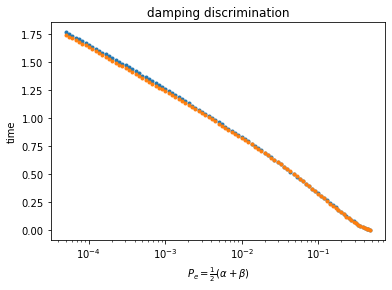

In [9]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))

ax = plt.subplot(111)
plt.title("{} discrimination".format(mode))
lin=6
ax.plot([avg_err_alpha(b) for b in boundsB[:len(stop_time1)]],stop_time1, '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot([avg_err_alpha(b) for b in boundsB[:len(stop_time1)]],stop_time0, '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)
#ax.plot(0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),[times[ind] for ind in indis] ,color="black", label="deterministic")
#ax.scatter( 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),[times[ind] for ind in indis], color="black")

ax.set_xscale("log")
ax.set_ylabel("time")
ax.set_xlabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')
#ax.legend(prop={"size":15})

In [115]:
boundsB/mu

array([0.        , 0.00926052, 0.01852104, 0.02778156, 0.03704208,
       0.0463026 , 0.05556312, 0.06482364, 0.07408415, 0.08334467,
       0.09260519, 0.10186571, 0.11112623, 0.12038675, 0.12964727,
       0.13890779, 0.14816831, 0.15742883, 0.16668935, 0.17594987,
       0.18521039, 0.19447091, 0.20373143, 0.21299194, 0.22225246,
       0.23151298, 0.2407735 , 0.25003402, 0.25929454, 0.26855506,
       0.27781558, 0.2870761 , 0.29633662, 0.30559714, 0.31485766,
       0.32411818, 0.3333787 , 0.34263922, 0.35189973, 0.36116025,
       0.37042077, 0.37968129, 0.38894181, 0.39820233, 0.40746285,
       0.41672337, 0.42598389, 0.43524441, 0.44450493, 0.45376545,
       0.46302597, 0.47228649, 0.48154701, 0.49080752, 0.50006804,
       0.50932856, 0.51858908, 0.5278496 , 0.53711012, 0.54637064,
       0.55563116, 0.56489168, 0.5741522 , 0.58341272, 0.59267324,
       0.60193376, 0.61119428, 0.6204548 , 0.62971531, 0.63897583,
       0.64823635, 0.65749687, 0.66675739, 0.67601791, 0.68527

In [116]:
stop_time0

array([2.00000000e-05, 1.53464149e-03, 4.93169951e-03, 1.00378175e-02,
       1.68170183e-02, 2.50240900e-02, 3.45296292e-02, 4.58913027e-02,
       5.85467488e-02, 7.22492515e-02, 8.78239245e-02, 1.02820959e-01,
       1.19656296e-01, 1.38154008e-01, 1.57567530e-01, 1.76243993e-01,
       1.95775345e-01, 2.16079226e-01, 2.35820501e-01, 2.57813363e-01,
       2.81542980e-01, 3.02843604e-01, 3.24754353e-01, 3.47243762e-01,
       3.69043352e-01, 3.91160761e-01, 4.13510598e-01, 4.36837941e-01,
       4.58297523e-01, 4.80275774e-01, 5.01495063e-01, 5.24034484e-01,
       5.43078927e-01, 5.64150560e-01, 5.84729436e-01, 6.04158254e-01,
       6.23809127e-01, 6.44347559e-01, 6.65903222e-01, 6.84926074e-01,
       7.03527943e-01, 7.23848760e-01, 7.44803270e-01, 7.63966363e-01,
       7.82365170e-01, 8.00056033e-01, 8.18256635e-01, 8.37336695e-01,
       8.54494162e-01, 8.72934617e-01, 8.92770346e-01, 9.12954139e-01,
       9.31009089e-01, 9.50817558e-01, 9.69752505e-01, 9.88860367e-01,
      

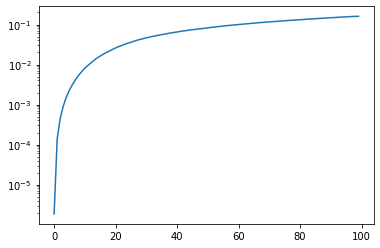

In [123]:
ax=plt.subplot(111)
ax.plot(stop_time0/mu)
ax.set_yscale("log")

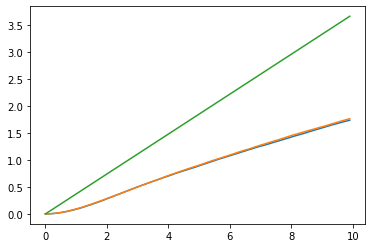

In [118]:
plt.plot(boundsB,stop_time0)
plt.plot(boundsB,stop_time1)
plt.plot(boundsB, boundsB/mu)

In [94]:
def give_avg(b, mu):
    return np.exp(-b)/mu

In [96]:
np.exp(-boundsB)/mu

array([9.26051933e-02, 8.37926440e-02, 7.58187196e-02, 6.86036145e-02,
       6.20751174e-02, 5.61678890e-02, 5.08228076e-02, 4.59863780e-02,
       4.16101956e-02, 3.76504619e-02, 3.40675468e-02, 3.08255910e-02,
       2.78921482e-02, 2.52378594e-02, 2.28361595e-02, 2.06630116e-02,
       1.86966661e-02, 1.69174431e-02, 1.53075355e-02, 1.38508309e-02,
       1.25327501e-02, 1.13401012e-02, 1.02609479e-02, 9.28448960e-03,
       8.40095360e-03, 7.60149716e-03, 6.87811907e-03, 6.22357950e-03,
       5.63132760e-03, 5.09543593e-03, 4.61054109e-03, 4.17179010e-03,
       3.77479178e-03, 3.41557285e-03, 3.09053812e-03, 2.79643453e-03,
       2.53031860e-03, 2.28952695e-03, 2.07164965e-03, 1.87450612e-03,
       1.69612328e-03, 1.53471581e-03, 1.38866829e-03, 1.25651903e-03,
       1.13694543e-03, 1.02875077e-03, 9.30852192e-04, 8.42269894e-04,
       7.62117316e-04, 6.89592265e-04, 6.23968884e-04, 5.64590394e-04,
       5.10862515e-04, 4.62247519e-04, 4.18258851e-04, 3.78456259e-04,
      

In [13]:
alpha = np.array(list(deter["h1/h0"].values()))
beta = np.array(list(deter["h0/h1"].values()))

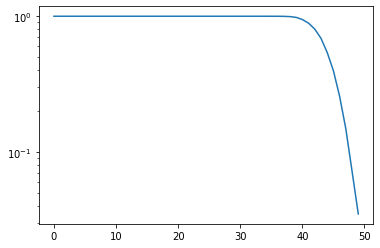

In [17]:
ax = plt.subplot(111)
ax.plot(alpha[-3,:])
ax.set_yscale("log")

In [18]:
ind_stop_times = [np.argmin(np.abs(times - stop_time0[ind])) for ind in range(len(stop_time0))]

In [20]:
indis_alpha_is_b = np.zeros((alpha.shape[0], len(boundsB)))
for contour, bo in enumerate(range(alpha.shape[0])):
    indis_alpha_is_b[contour] = [np.argmin(np.abs(alpha[contour,:] - avg_err_alpha(b))) for b in boundsB]

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [73]:
def ggiulio_prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    #S= np.sqrt(2*mu)

    #div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  mu# abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div, mu

In [82]:
pars = give_def_params_discrimination(flip=1, mode = "damping")
params, exp_path = check_params(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

mu= ggiulio_prob(100, 3, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)


In [ ]:
plt.plot(np.abs(np.log(np.array([avg_err_alpha(b) for b in boundsB])))/mu)
plt.plot(0.5*(stop_time0 + stop_time1))

In [ ]:
ax = plt.subplot(111)
ax.plot(alpha[-1,:],timind,'.')
ax.plot([avg_err_alpha(b) for b in boundsB],[times[int(np.argmin(np.abs(times - ss)))] for ss in stop_time0])
ax.plot([avg_err_alpha(b) for b in boundsB],4*np.array([times[int(np.argmin(np.abs(times - ss)))] for ss in stop_time0]))

ax.set_xscale("log")

In [26]:
times_det_alpha_is_b = np.zeros((alpha.shape[0], len(boundsB)))
for contour, bo in enumerate(range(alpha.shape[0])):
    times_det_alpha_is_b[contour] = [times[int(i)] for i in indis_alpha_is_b[contour]]

In [90]:
timind = [times[ind] for ind in indis]

In [89]:
#plt.plot(timind, [avg_err_alpha(b) for b in boundsB])
plt.plot(timind, alpha[0,:])
plt.plot(stop_time0, [avg_err_alpha(b) for b in boundsB])

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


Error in callback <function flush_figures at 0x2afd67df4840> (for post_execute):


KeyboardInterrupt: 

In [35]:
indis_alpha_is_b[-1,:]

array([ 0., 45., 45., 45., 45., 45., 45., 46., 46., 46., 46., 46., 46.,
       47., 47., 47., 47., 47., 47., 47., 47., 48., 48., 48., 48., 48.,
       48., 48., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49.])

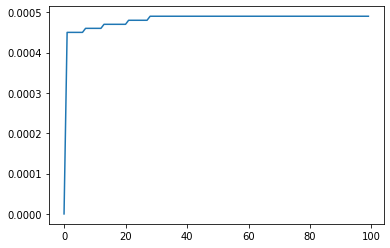

In [29]:
plt.plot(times_det_alpha_is_b[-1])
#plt.plot(stop_time0)

In [ ]:
for itraj in tqdm(range(2,3000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        stop["h0/h1"][itraj] = []
        stop["h1/h0"][itraj] = []
        ll += log_lik_ratio
        ll0+= log_lik_ratio_swap
        n+=1
        for ind, time_index in enumerate(indis):
            h0_deter = log_lik_ratio[time_index] <= 0
            h1_deter = log_lik_ratio_swap[time_index] <= 0
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
            
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
        for b in boundsB:
            stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))


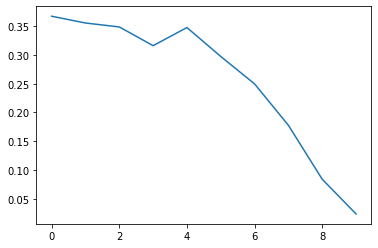

In [24]:
plt.plot(np.array(deter["h1/h0"]))

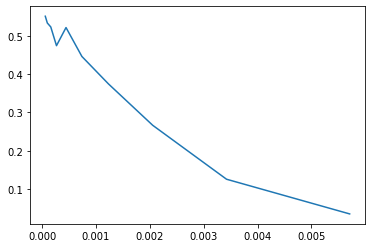

In [21]:
plt.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]))

NameError: name 'ind_max_traj' is not defined

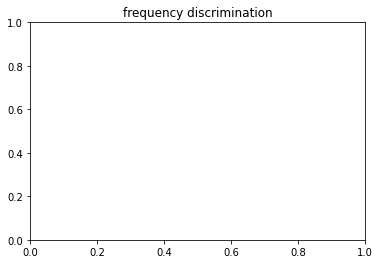

In [120]:
ax = plt.subplot(111)
plt.title("frequency discrimination")
lin=6
ax.plot(stop_time1, [avg_err_alpha(b) for b in boundsB[:len(stopps1[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot(stop_time0, [avg_err_alpha(b) for b in boundsB[:len(stopps0[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)
ax.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),color="black", label="deterministic")
ax.scatter([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]), color="black")

ax.set_xlabel("time")
ax.set_ylabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')
ax.legend(prop={"size":15})

In [471]:
ll *= len(stop["h0/h1"])**2
ll0 *= len(stop["h0/h1"])**2

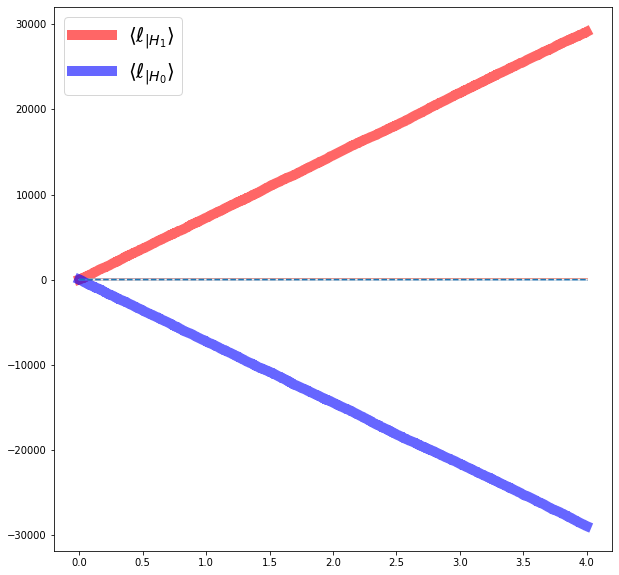

In [14]:

colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")

plt.figure(figsize=(10,10))
alphaMean=0.6
plt.plot(times, ll[:-1],linewidth=10, alpha=alphaMean,  color="red", label=r'$\langle \ell_{|H_1}\rangle$')
Ntraj = 10
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]
             
for ii, itraj in enumerate(range(1,Ntraj)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
    plt.plot(times,log_lik_ratio[:-1], c=c1[ii], alpha=0.75)
    plt.plot(times, log_lik_ratio_swap[:-1],c=c0[ii], alpha=0.75)
plt.plot(times,ll0[:-1], linewidth=10, alpha=alphaMean, color="blue", label=r'$\langle \ell_{|H_0}\rangle$')
plt.plot(times, np.zeros(len(ll0)-1),"--")

plt.legend(prop={"size":20})

In [476]:
import os 
freq_dir = get_def_path(mode="continuous")+"freq_discrimination/"
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time1",stop_time1)
np.save(freq_dir+"stop_time0",stop_time0)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))